<html><head><meta content="text/html; charset=UTF-8" http-equiv="content-type"><style type="text/css">ol</style></head><body class="c5"><p class="c0 c4"><span class="c3"></span></p><p class="c2 title" id="h.rrbabt268i6e"><h1>CaImAn&rsquo;s Demo pipeline</h1></p><p class="c0"><span class="c3">This notebook will help to demonstrate the process of CaImAn and how it uses different functions to denoise, deconvolve and demix neurons from a Calcium Imaging Video. </span></p>
<p><img src="../../docs/img/quickintro.png" /></p>
<p class="c0"><span class="c3">More information can be found in CaImAn&rsquo;s documentation. </span></p>
</html>



In [1]:
from __future__ import division
from __future__ import print_function
from builtins import zip
from builtins import str
from builtins import map
from builtins import range
from past.utils import old_div

import glob
import matplotlib.pyplot as plt
import numpy as np
import pylab as pl
import os
os.path.isfile('/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918')
import sys
import time
import cv2
try:
    cv2.setNumThreads(0)
except:
    pass

try:
    if __IPYTHON__:
        print((1))
        # this is used for debugging purposes only. allows to reload classes
        # when changed
        get_ipython().magic('load_ext autoreload')
        get_ipython().magic('autoreload 2')
except NameError:
    print('Not IPYTHON')
    pass

import caiman as cm
from caiman.utils.utils import download_demo
from caiman.utils.visualization import plot_contours, nb_view_patches, nb_plot_contour
from caiman.source_extraction.cnmf import cnmf as cnmf
from caiman.motion_correction import MotionCorrect
from caiman.source_extraction.cnmf.utilities import detrend_df_f
from caiman.components_evaluation import estimate_components_quality_auto
import bokeh.plotting as bpl
bpl.output_notebook()

1


Loading BokehJS ...

### Setup some parameters

In [2]:
# dataset dependent parameters
fname = ['/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/071918_f1_T1_G.tiff',
         '/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/071918_f1_T2_G.tiff'
         ]  

# filename to be processed
fr = 4                             # imaging rate in frames per second
decay_time = 0.4                    # length of a typical transient in seconds

# motion correction parameters
niter_rig = 1               # number of iterations for rigid motion correction
max_shifts = (6, 6)         # maximum allow rigid shift
splits_rig = 2          # for parallelization split the movies in  num_splits chuncks across time
strides = (48, 48)          # start a new patch for pw-rigid motion correction every x pixels
overlaps = (24, 24)         # overlap between pathes (size of patch strides+overlaps)
splits_els = 2         # for parallelization split the movies in  num_splits chuncks across time
upsample_factor_grid = 4    # upsample factor to avoid smearing when merging patches
max_deviation_rigid = 3     # maximum deviation allowed for patch with respect to rigid shifts

# parameters for source extraction and deconvolution
p = 1                       # order of the autoregressive system
gnb = 2                     # number of global background components
merge_thresh = 0.8          # merging threshold, max correlation allowed
rf = 15                     # half-size of the patches in pixels. e.g., if rf=25, patches are 50x50
stride_cnmf = 6             # amount of overlap between the patches in pixels
K = 4                       # number of components per patch
gSig = [4, 4]               # expected half size of neurons
init_method = 'greedy_roi'  # initialization method (if analyzing dendritic data using 'sparse_nmf')
is_dendrites = False        # flag for analyzing dendritic data
alpha_snmf = None           # sparsity penalty for dendritic data analysis through sparse NMF

# parameters for component evaluation
min_SNR = 2.5               # signal to noise ratio for accepting a component
rval_thr = 0.8              # space correlation threshold for accepting a component
cnn_thr = 0.8               # threshold for CNN based classifier

Download the dataset if not already present

In [3]:
if fname[0] in ['Sue_2x_3000_40_-46.tif','demoMovie.tif']:
    fname = [download_demo(fname[0])]

Play the movie (optional). This will require loading the movie in memory which in general is not needed by the pipeline. Displaying the movie uses the OpenCV library. Press `q` to close the video panel.

In [4]:
m_orig = cm.load_movie_chain(fname[:2])
downsample_ratio = 0.2
offset_mov = -np.min(m_orig[:100])  # make the dataset mostly non-negative
m_orig.resize(1, 1, downsample_ratio).play(
gain=10, offset=offset_mov, fr=4, magnification=2)

100%|██████████| 2/2 [00:00<00:00,  4.99it/s]


reshaping along z


##### Setup a cluster

In [5]:
#%% start a cluster for parallel processing
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='local', n_processes=None, single_thread=False)

0
0
10
10
20
20
30
30
40
40
50
50


/home/murthyhacker/CaImAn/caiman/motion_correction.py:2457: RuntimeWarning: Mean of empty slice
  new_temp = np.nanmean(mc, 0)


0
0
10
10
20
20
30
30
40
40
50
50


/home/murthyhacker/CaImAn/caiman/motion_correction.py:2457: RuntimeWarning: Mean of empty slice
  new_temp = np.nanmean(mc, 0)
/home/murthyhacker/CaImAn/caiman/motion_correction.py:2457: RuntimeWarning: Mean of empty slice
  new_temp = np.nanmean(mc, 0)


0
0
0
0
0
0


/home/murthyhacker/anaconda3/envs/caiman/lib/python3.6/site-packages/past/utils/__init__.py:95: RuntimeWarning: invalid value encountered in true_divide
  return a / b
/home/murthyhacker/anaconda3/envs/caiman/lib/python3.6/site-packages/past/utils/__init__.py:95: RuntimeWarning: invalid value encountered in true_divide
  return a / b
/home/murthyhacker/anaconda3/envs/caiman/lib/python3.6/site-packages/past/utils/__init__.py:95: RuntimeWarning: invalid value encountered in true_divide
  return a / b
/home/murthyhacker/anaconda3/envs/caiman/lib/python3.6/site-packages/past/utils/__init__.py:95: RuntimeWarning: invalid value encountered in true_divide
  return a / b
/home/murthyhacker/anaconda3/envs/caiman/lib/python3.6/site-packages/past/utils/__init__.py:95: RuntimeWarning: invalid value encountered in true_divide
  return a / b
/home/murthyhacker/anaconda3/envs/caiman/lib/python3.6/site-packages/past/utils/__init__.py:95: RuntimeWarning: invalid value encountered in true_divide
  retur

10
10
10
10
10
10
20
20
20
20
20
20
30
30
30
30
30
30
40
40
40
40
40
40
50
50
50
50
50
50
0


/home/murthyhacker/CaImAn/caiman/motion_correction.py:2457: RuntimeWarning: Mean of empty slice
  new_temp = np.nanmean(mc, 0)


10
20
30
40
50
0
0
10
10
20
20
30
30
40
40
50
50


/home/murthyhacker/CaImAn/caiman/motion_correction.py:2457: RuntimeWarning: Mean of empty slice
  new_temp = np.nanmean(mc, 0)


0
0
0
0
0
0
10
10
10
10
10
10
20
20
20
20
20
20
30
30
30
30
30
30
40
40
40
40
40
40
50
50
50
50
50
50
0


/home/murthyhacker/CaImAn/caiman/motion_correction.py:2457: RuntimeWarning: Mean of empty slice
  new_temp = np.nanmean(mc, 0)


10
20
30
40
50
0
0
10
10
20
20
30
30
40
40
50
50


## Motion Correction
First we create a motion correction object with the parameters specified. Note that the file is not loaded in memory

In [6]:
# first we create a motion correction object with the parameters specified
min_mov = min(cm.load(fname[0], subindices=slice(200)).min(),0) 
        # this will be subtracted from the movie to make it non-negative 

mc = MotionCorrect(fname[:2], min_mov,
                   dview=dview, max_shifts=max_shifts, niter_rig=niter_rig,
                   splits_rig=splits_rig, 
                   strides= strides, overlaps= overlaps, splits_els=splits_els,
                   upsample_factor_grid=upsample_factor_grid,
                   max_deviation_rigid=max_deviation_rigid, 
                   shifts_opencv = True, nonneg_movie = True)
# note that the file is not loaded in memory

Now perform motion correction. From the movie above we see that the dateset exhibits non-uniform motion. We will perform piecewise rigid motion correction using the NoRMCorre algorithm.

In [7]:
%%capture
#%% Run piecewise-rigid motion correction using NoRMCorre
mc.motion_correct_pwrigid(save_movie=True)
m_els = cm.load(mc.fname_tot_els)
bord_px_els = np.ceil(np.maximum(np.max(np.abs(mc.x_shifts_els)),
                                 np.max(np.abs(mc.y_shifts_els)))).astype(np.int)  
    # maximum shift to be used for trimming against NaNs

Inspect the results by comparing the original movie. A more detailed presentation of the motion correction method can be found in the [demo motion correction](./demo_motion_correction.ipynb) notebook.

In [8]:
#%% compare with original movie
cm.concatenate([m_orig.resize(1, 1, downsample_ratio)+offset_mov,
                m_els.resize(1, 1, downsample_ratio)], 
               axis=2).play(fr=8, gain=15, magnification=2, offset=0)  # press q to exit

reshaping along z
reshaping along z


## Memory mapping 

The cell below memory maps the file in order `C` and then loads the new memory mapped file.

In [9]:
#%% MEMORY MAPPING
# memory map the file in order 'C'
fnames = mc.fname_tot_els   # name of the pw-rigidly corrected file.
border_to_0 = bord_px_els     # number of pixels to exclude
fname_new = cm.save_memmap(fnames, base_name='memmap_', order = 'C',
                           border_to_0 = bord_px_els) # exclude borders

# now load the file
Yr, dims, T = cm.load_memmap(fname_new)
d1, d2 = dims
images = np.reshape(Yr.T, [T] + list(dims), order='F') 
    #load frames in python format (T x X x Y)

RECOMPUTING EACH FILE MEMORY MAP
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/071918_f1_T1_G._els__d1_301_d2_300_d3_1_order_F_frames_108_.mmap
loading in memory
mmap
SAVING WITH numpy.tofile()
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/071918_f1_T2_G._els__d1_301_d2_300_d3_1_order_F_frames_109_.mmap
loading in memory
mmap
SAVING WITH numpy.tofile()
('/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0000_d1_301_d2_300_d3_1_order_C_frames_108_.mmap', 108)
('/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0001_d1_301_d2_300_d3_1_order_C_frames_109_.mmap', 109)
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap__d1_301_d2_300_d3_1_order_C_frames_217_.mmap
(903, 217)
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0000_d1_301_d2_300_d3_1_order_C_frames_108_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0001_d1_301_d2_300_

done
(903, 217)
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0000_d1_301_d2_300_d3_1_order_C_frames_108_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0001_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
(28896, 29799)
done
(903, 217)
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0000_d1_301_d2_300_d3_1_order_C_frames_108_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0001_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
(29799, 30702)
done
(903, 217)
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0000_d1_301_d2_300_d3_1_order_C_frames_108_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0001_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
(30702, 31605)
done
(903, 217)
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0000_d1_301_d2_300_d3_1_order_C_frames_108_.mmap
/home/murthyhacker/Desktop/Rachele/da

/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0001_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
(64113, 65016)
done
(903, 217)
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0000_d1_301_d2_300_d3_1_order_C_frames_108_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0001_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
(65016, 65919)
done
(903, 217)
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0000_d1_301_d2_300_d3_1_order_C_frames_108_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0001_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
(65919, 66822)
done
(903, 217)
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0000_d1_301_d2_300_d3_1_order_C_frames_108_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0001_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
(66822, 67725)
done
(903, 217)
/home/murthyhacker/Des

Now restart the cluster to clean up the memory

In [10]:
#%% restart cluster to clean up memory
cm.stop_server(dview=dview)
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='local', n_processes=None, single_thread=False)

(217, 31, 31)
(217, 31, 31)
(217, 31, 31)
using 1 processes
(217, 31, 31)
using 1 processes
(217, 31, 30)
(217, 31, 31)
using 1 processes
using 225 pixels per process
using 225 pixels per process
using 1 processes
using 1 processes
using 225 pixels per process
using 5000 block_size
using 5000 block_size
preprocessing ...
preprocessing ...
checking if missing data
checking if missing data
using 5000 block_size
using 225 pixels per process
using 1 processes
using 225 pixels per process
preprocessing ...
checking if missing data
using 225 pixels per process
using 5000 block_size
using 5000 block_size
using 5000 block_size
preprocessing ...
preprocessing ...
checking if missing data
preprocessing ...
checking if missing data
checking if missing data
initializing ...
initializing ...
Noise Normalization
initializing ...
Noise Normalization
Spatial Downsampling 2-photon
Noise Normalization
Spatial Downsampling 2-photon
reshaping along x and y
Spatial Downsampling 2-photon
reshaping along x a

using 1 processes
using 225 pixels per process
using 225 pixels per process
using 5000 block_size
using 5000 block_size
preprocessing ...
False
using 5000 block_size
preprocessing ...
checking if missing data
checking if missing data
preprocessing ...
preprocessing ...
checking if missing data
checking if missing data
(217, 31, 31)
using 1 processes
(Hals) Refining Components...
using 225 pixels per process
initializing ...
using 5000 block_size
initializing ...
preprocessing ...
initializing ...
Noise Normalization
checking if missing data
Noise Normalization
Spatial Downsampling 2-photon
Noise Normalization
Spatial Downsampling 2-photon
reshaping along x and y
reshaping along x and y
Spatial Downsampling 2-photon
reshaping along x and y
(108, 15)
(108, 15)
(108, 15)
initializing ...
reshaping along z
reshaping along z
reshaping along z
Noise Normalization
False
***** OPENCV!!!!
***** OPENCV!!!!
Spatial Downsampling 2-photon
***** OPENCV!!!!
Roi Extraction...
Roi Extraction...
Roi Ext

preprocessing ...
using 5000 block_size
preprocessing ...
using 5000 block_size
preprocessing ...
checking if missing data
checking if missing data
checking if missing data
checking if missing data
preprocessing ...
USING ROLLING SUM FOR INITIALIZATION....
checking if missing data
initializing ...
Noise Normalization
initializing ...
Spatial Downsampling 2-photon
Noise Normalization
initializing ...
reshaping along x and y
Noise Normalization
Spatial Downsampling 2-photon
reshaping along x and y
Spatial Downsampling 2-photon
reshaping along x and y
(108, 15)
initializing ...
(108, 15)
reshaping along z
Noise Normalization
***** OPENCV!!!!
initializing ...
(108, 15)
Noise Normalization
Spatial Downsampling 2-photon
Roi Extraction...
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
Spatial Downsampling 2-photon
reshaping along x and y
reshaping along z
USING ROLLING SUM FOR INITIALIZATION....
reshaping along z
(108, 15)
***** OPENCV!!!!
***** OPEN

reshaping along x and y
(108, 15)
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
reshaping along x and y
reshaping along z
***** OPENCV!!!!
(108, 15)
USING ROLLING SUM FOR INITIALIZATION....
reshaping along z
Roi Extraction...
***** OPENCV!!!!
(217, 31, 31)
using 1 processes
Roi Extraction...
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
using 225 pixels per process
USING ROLLING SUM FOR INITIALIZATION....
initializing ...
using 5000 block_size
preprocessing ...
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
checking if missing data
Noise Normalization
Spatial Downsampling 2-photon
reshaping along x and y
initializing ...
(108, 15)
reshaping along z
(Hals) Refining Components...
USING ROLLING SUM FOR INITIALIZATION....
***** OPENCV!!!!
Noise Normalization
Roi Extraction...
Spatial Downsampling 2-photon
Greedy initialization of spatial and temporal components

preprocessing ...
(217, 31, 31)
using 1 processes
Spatial Downsampling 2-photon
checking if missing data
initializing ...
reshaping along x and y
using 225 pixels per process
Noise Normalization
(108, 15)
using 5000 block_size
initializing ...
initializing ...
Spatial Downsampling 2-photon
preprocessing ...
reshaping along z
Noise Normalization
reshaping along x and y
checking if missing data
Spatial Downsampling 2-photon
***** OPENCV!!!!
reshaping along x and y
Roi Extraction...
Noise Normalization
(108, 15)
(108, 15)
reshaping along z
***** OPENCV!!!!
Spatial Downsampling 2-photon
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
reshaping along z
reshaping along x and y
(108, 15)
***** OPENCV!!!!
Roi Extraction...
initializing ...
USING ROLLING SUM FOR INITIALIZATION....
Noise Normalization
reshaping along z
***** OPENCV!!!!
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
Roi Extraction...
Spatial Down

checking if missing data
using 225 pixels per process
using 5000 block_size
Roi Extraction...
preprocessing ...
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
USING ROLLING SUM FOR INITIALIZATION....
USING ROLLING SUM FOR INITIALIZATION....
checking if missing data
(Hals) Refining Components...
initializing ...
Noise Normalization
Spatial Downsampling 2-photon
initializing ...
Noise Normalization
Spatial Downsampling 2-photon
reshaping along x and y
(108, 15)
reshaping along x and y
(108, 15)
reshaping along z
reshaping along z
***** OPENCV!!!!
***** OPENCV!!!!
False
Roi Extraction...
Roi Extraction...
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
(Hals) Refining Components...
(217, 31, 31)
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
initializing ...
USING ROLLING SUM FOR INITIALIZATION....
Noise Normalization
using 1 processes
USING ROLLING SUM FOR INITI

***** OPENCV!!!!
Roi Extraction...
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
initializing ...
USING ROLLING SUM FOR INITIALIZATION....
Roi Extraction...
Noise Normalization
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
Spatial Downsampling 2-photon
USING ROLLING SUM FOR INITIALIZATION....
reshaping along x and y
(108, 15)
reshaping along z
(Hals) Refining Components...
***** OPENCV!!!!
(Hals) Refining Components...
False
Roi Extraction...
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
(217, 31, 31)
using 1 processes
USING ROLLING SUM FOR INITIALIZATION....
using 225 pixels per process
using 5000 block_size
(Hals) Refining Components...
(Hals) Refining Components...
preprocessing ...
checking if missing data
False
False
(217, 31, 31)
using 1 processes
using 225 pixels per process
(217, 31, 31)
using 5000 block_size
preprocessing ...
checking if missing d

Roi Extraction...
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
reshaping along x and y
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
USING ROLLING SUM FOR INITIALIZATION....
(108, 15)
(217, 31, 31)
USING ROLLING SUM FOR INITIALIZATION....
False
using 1 processes
reshaping along z
(217, 31, 31)
using 225 pixels per process
***** OPENCV!!!!
Roi Extraction...
using 1 processes
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
using 5000 block_size
using 225 pixels per process
preprocessing ...
USING ROLLING SUM FOR INITIALIZATION....
checking if missing data
using 5000 block_size
preprocessing ...
False
checking if missing data
(217, 31, 31)
using 1 processes
using 225 pixels per process
using 5000 block_size
(Hals) Refining Components...
preprocessing ...
checking if missing data
(Hals) Refining Components...
initializing ...
Noise Normalization
False
initializ

False
(217, 31, 31)
using 1 processes
using 225 pixels per process
False
False
using 5000 block_size
preprocessing ...
False
checking if missing data
(217, 30, 31)
(217, 30, 31)
(217, 31, 30)
using 1 processes
using 225 pixels per process
using 1 processes
using 225 pixels per process
using 1 processes
using 5000 block_size
using 5000 block_size
preprocessing ...
checking if missing data
preprocessing ...
using 225 pixels per process
checking if missing data
using 5000 block_size
preprocessing ...
checking if missing data
initializing ...
Noise Normalization
Spatial Downsampling 2-photon
reshaping along x and y
initializing ...
Noise Normalization
(108, 15)
Spatial Downsampling 2-photon
initializing ...
reshaping along x and y
Noise Normalization
reshaping along z
(108, 15)
***** OPENCV!!!!
Spatial Downsampling 2-photon
reshaping along z
Roi Extraction...
***** OPENCV!!!!
Roi Extraction...
initializing ...
reshaping along x and y
Greedy initialization of spatial and temporal components

/home/murthyhacker/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/signal/spectral.py:1633: UserWarning: nperseg = 256 is greater than input length  = 217, using nperseg = 217
  .format(nperseg, input_length))
/home/murthyhacker/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/signal/spectral.py:1633: UserWarning: nperseg = 256 is greater than input length  = 217, using nperseg = 217
  .format(nperseg, input_length))
/home/murthyhacker/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/signal/spectral.py:1633: UserWarning: nperseg = 256 is greater than input length  = 217, using nperseg = 217
  .format(nperseg, input_length))
/home/murthyhacker/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/signal/spectral.py:1633: UserWarning: nperseg = 256 is greater than input length  = 217, using nperseg = 217
  .format(nperseg, input_length))
/home/murthyhacker/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/signal/spectral.py:1633: UserWarning: nperseg = 256 i

tB:-2.0,tA:5.0
Computing event exceptionality delta
tB:-2.0,tA:5.0
tB:-2.0,tA:5.0
tB:-2.0,tA:5.0
Computing event exceptionality delta
Computing event exceptionality delta
Removing Baseline
tB:-2.0,tA:5.0
binning data ...
Computing event exceptionality delta
tB:-2.0,tA:5.0
Removing Baseline
Computing event exceptionality delta
binning data ...
Removing Baseline
Computing event exceptionality delta
interpolating data ...
binning data ...
(6, 50)
interpolating data ...
interpolating data ...
Removing Baseline
Removing Baseline
(6, 50)
Removing Baseline
binning data ...
(6, 50)
interpolating data ...
binning data ...
(6, 50)
Computing event exceptionality
interpolating data ...
Computing event exceptionality
binning data ...
Computing event exceptionality
Computing event exceptionality
Evaluating spatial footprint
Evaluating spatial footprint
Evaluating spatial footprint
interpolating data ...
Evaluating spatial footprint
(6, 50)
(6, 50)
Computing event exceptionality
components evaluated:

## Run CNMF on patches in parallel

<p> <img src="../../docs/img/cnmf1.png" /> </p>

- The FOV is split is different overlapping patches that are subsequently processed in parallel by the CNMF algorithm.
- The results from all the patches are merged with special attention to idendtified components on the border.
- The results are then refined by additional CNMF iterations.

In [11]:
%%capture
#%% RUN CNMF ON PATCHES

# First extract spatial and temporal components on patches and combine them
# for this step deconvolution is turned off (p=0)
t1 = time.time()

cnm = cnmf.CNMF(n_processes=1, k=K, gSig=gSig, merge_thresh= merge_thresh, 
                p = 0,  dview=dview, rf=rf, stride=stride_cnmf, memory_fact=1,
                method_init=init_method, alpha_snmf=alpha_snmf, 
                only_init_patch = False, gnb = gnb, border_pix = bord_px_els) 
cnm = cnm.fit(images)

plot contours of identified components against correlation image

/home/murthyhacker/CaImAn/caiman/summary_images.py:206: RuntimeWarning: invalid value encountered in true_divide
  w_mov = (Y - np.mean(Y, axis=0)) / np.std(Y, axis=0)
/home/murthyhacker/CaImAn/caiman/utils/visualization.py:901: UserWarning: The way to call utilities.plot_contours has changed. Look at the definition for more details.
  "Look at the definition for more details.")


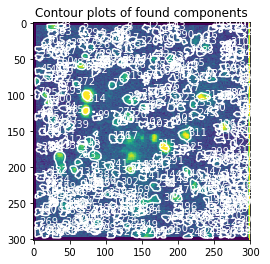

In [12]:
#%% plot contours of found components
Cn = cm.local_correlations(images.transpose(1,2,0))
Cn[np.isnan(Cn)] = 0
plt.figure(); crd = plot_contours(cnm.A, Cn, thr=0.9)
plt.title('Contour plots of found components')

## Component Evaluation

The processing in patches creates several spurious components. These are filtered out by evaluating each component using three different criteria:

- the shape of each component must be correlated with the data at the corresponding location within the FOV
- a minimum peak SNR is required over the length of a transient
- each shape passes a CNN based classifier

<img src="../../docs/img/evaluationcomponent.png"/>

In [13]:
#%% COMPONENT EVALUATION
# the components are evaluated in three ways:
#   a) the shape of each component must be correlated with the data
#   b) a minimum peak SNR is required over the length of a transient
#   c) each shape passes a CNN based classifier

idx_components, idx_components_bad, SNR_comp, r_values, cnn_preds = \
    estimate_components_quality_auto(images, cnm.A, cnm.C, cnm.b, cnm.f, 
                                     cnm.YrA, fr, decay_time, gSig, dims, 
                                     dview = dview, min_SNR=min_SNR, 
                                     r_values_min = rval_thr, use_cnn = False, 
                                     thresh_cnn_lowest = cnn_thr)

EVALUATING IN PARALLEL... NOT RETURNING ERFCs


Plot contours of selected and rejected components

/home/murthyhacker/CaImAn/caiman/utils/visualization.py:901: UserWarning: The way to call utilities.plot_contours has changed. Look at the definition for more details.
  "Look at the definition for more details.")


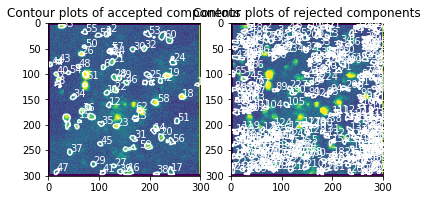

In [14]:
#%% PLOT COMPONENTS

plt.figure();
plt.subplot(121); crd_good = cm.utils.visualization.plot_contours(cnm.A[:,idx_components], Cn, thr=.8, vmax=0.75)
plt.title('Contour plots of accepted components')
plt.subplot(122); crd_bad = cm.utils.visualization.plot_contours(cnm.A[:,idx_components_bad], Cn, thr=.8, vmax=0.75)
plt.title('Contour plots of rejected components')

View traces of accepted and rejected components. Note that if you get data rate error you can start Jupyter notebooks using:
'jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10'

In [15]:
# accepted components
nb_view_patches(Yr, cnm.A.tocsc()[:, idx_components], cnm.C[idx_components], 
                cnm.b, cnm.f, dims[0], dims[1], YrA=cnm.YrA[idx_components], image_neurons =Cn,
                denoised_color = 'red');

#np.set_printoptions(threshold=np.nan)




          1          2           3          4           5          6    \
1    0.000000   0.000000   10.569877   0.000000    0.748636   0.000000   
2    0.832501  17.826505   28.395823   0.000000    0.000000  24.072113   
3   53.512184  56.601095   34.291748  54.897207   97.749775  43.767039   
4    0.000000   2.059993   16.238248  17.525734    6.292085   5.615774   
5   44.556567  24.695935    7.357902  34.478673    6.919203  15.816577   
6   79.085235  64.685338   75.096561  52.857807   30.340907   3.649623   
7    0.000000  29.536833    0.000000  41.189946   44.183133   1.862925   
8    0.000000   2.184919   18.005829   6.544306    0.000000   0.000000   
9    6.714547  62.867172   32.609803  13.079715   18.247033   0.000000   
10   0.000000   3.880220   27.925479   0.000000    9.850584  22.503835   
11   0.000000   1.549762    0.000000   2.680464   17.243609  40.044280   
12   0.000000  27.283486   10.640799   0.000000   46.017716  27.632985   
13   0.000000   0.000000    2.932548  

In [16]:
# rejected components
if len(idx_components_bad) > 0:
    nb_view_patches(Yr, cnm.A.tocsc()[:, idx_components_bad], cnm.C[idx_components_bad], 
                    cnm.b, cnm.f, dims[0], dims[1], YrA=cnm.YrA[idx_components_bad], image_neurons =Cn,
                    denoised_color = 'red');
else:
    print("No components were rejected.")

           1          2          3          4          5          6    \
1    12.764624   0.000000   4.317872  15.961169   6.205511   0.000000   
2    15.187729  53.453656   8.622600  28.798605  24.212523  16.937815   
3     3.624669   1.695808  19.811225  19.214880  16.917912   7.655558   
4    28.095280  54.005312   7.758989  49.160565  33.709733  36.188096   
5    19.809894  35.482752  26.505321  59.483234  68.280503  73.676037   
6     8.849819   4.894105   0.000000  33.247468   3.877025   3.066642   
7    13.451518   0.000000  28.866508  14.103282   0.000000   0.000000   
8     9.132527   4.409296  25.946196  40.888697   0.196040  24.475270   
9     0.000000   0.000000   0.000000   0.000000  10.928407  32.005275   
10    2.646809  42.587897  14.708914   0.000000  16.071458   9.342363   
11   81.782632  29.822061  18.356544   0.000000   3.898228  33.275969   
12   28.778177  44.229835   0.000000  15.901302  16.939424  31.492888   
13   21.373271  23.756798  28.585206   0.358362   0

## Re-run (seeded) CNMF  on the full Field of View  

In [17]:
%%capture
#%% RE-RUN seeded CNMF on accepted patches to refine and perform deconvolution 
A_in, C_in, b_in, f_in = cnm.A[:,idx_components], cnm.C[idx_components], cnm.b, cnm.f
cnm2 = cnmf.CNMF(n_processes=1, k=A_in.shape[-1], gSig=gSig, p=p, dview=dview,
                merge_thresh=merge_thresh,  Ain=A_in, Cin=C_in, b_in = b_in,
                f_in=f_in, rf = None, stride = None, gnb = gnb, 
                method_deconvolution='oasis', check_nan = True)

cnm2 = cnm2.fit(images)

### Extract DF/F values

In [18]:
#%% Extract DF/F values

F_dff = detrend_df_f(cnm2.A, cnm2.b, cnm2.C, cnm2.f, YrA = cnm2.YrA, 
                      quantileMin=8, frames_window=250)



         1         2         3         4         5         6         7    \
1  -0.096509 -0.017625  0.029292 -0.117972 -0.051103 -0.045206 -0.010117   
2  -0.097970  0.116685  0.108133 -0.102227 -0.187382  0.168165 -0.054287   
3   0.043420  0.093483  0.047857  0.113490  0.158675  0.022350  0.157708   
4  -0.252236 -0.016080  0.016841  0.062315 -0.054543 -0.006799  0.141292   
5   0.060215  0.053312  0.030957  0.007674 -0.039475  0.011571  0.018457   
6   0.271521  0.202346  0.280579  0.157996  0.068303 -0.009327  0.051420   
7  -0.117043  0.222462  0.027725  0.302005  0.345654  0.027202 -0.149738   
8  -0.150755 -0.012542  0.048783  0.006645  0.000980 -0.084741 -0.170062   
9  -0.032802  0.364917  0.048533  0.042157  0.079491 -0.025326  0.268592   
10 -0.690910 -0.011901  0.659484 -0.370944  0.395809  0.722213 -0.328529   
11 -0.204360 -0.166445 -0.173783 -0.175946 -0.109729 -0.122578 -0.196645   
12 -0.140338  0.043012  0.058334 -0.063862  0.180424  0.017126  0.081058   
13 -0.085461

## Display final results

In [19]:
discard_traces_fluo=nb_view_patches(Yr,cnm2.A, cnm2.C, cnm2.b, cnm2.f,
                                    dims[0], dims[1], thr = 0.8, image_neurons=Cn,
                                    denoised_color='red')
print('you will may be need to change the data rate to generate this one: use jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10')

#from bokeh.plotting import figure
#from bokeh.io import show
#plt.figure();

#plt.imshow(np.reshape(cnm2.A[:,5-1].toarray(), dims, order='F'))

#plt.figure()

#plt.plot(F_dff[5-1][1:100])


           1           2           3          4          5          6    \
1    16.017395   16.017395   16.017395  16.017395  16.017395  16.017395   
2    13.949480   13.949480   13.949480  13.949480  13.949480  13.949480   
3    27.817379   27.817379   27.817379  46.192124  44.621000  43.184211   
4    14.126052   14.126052   14.126052  14.126052  14.126052  14.126052   
5    27.115637   26.709048   26.337225  25.997194  25.686237  25.401869   
6    74.212370   63.865262   55.213356  47.978918  41.929722  36.871586   
7    -0.372758    3.552248    3.200253   2.879825   2.588133   2.322600   
8     8.939120    8.939120    8.939120   8.939120   8.939120   8.939120   
9    13.874002   13.874002   13.874002  13.874002  13.874002  13.874002   
10    8.201735    8.201735    8.201735   8.201735   8.201735   8.201735   
11   20.927313   20.927313   20.927313  20.927313  20.927313  20.927313   
12    8.395042    8.395042    8.395042   8.395042   8.395042   8.395042   
13    9.160243    9.16024

you will may be need to change the data rate to generate this one: use jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10


<h1> closing, saving, and creating denoised version </h1>

In [20]:
save_results = False
if save_results:
    np.savez(os.path.join(os.path.split(fname_new)[0], 
                          os.path.split(fname_new)[1][:-4] + 'results_analysis.npz'),
             Cn=Cn, A=cnm2.A.todense(), C=cnm2.C,
             b=cnm2.b, f=cnm2.f, YrA=cnm2.YrA, sn=sn, d1=d1, d2=d2,
             idx_components=idx_components, idx_components_bad=idx_components_bad)

## stop cluster and clean up LOG files

In [21]:
#%% STOP CLUSTER and clean up log files
cm.stop_server(dview=dview)
log_files = glob.glob('*_LOG_*')
for log_file in log_files:
    os.remove(log_file)

We can inspect the denoised results by reconstructing the movie and playing alongside the original

In [22]:
#%% reconstruct denoised movie
denoised = cm.movie(cnm2.A.dot(cnm2.C) + \
                    cnm2.b.dot(cnm2.f)).reshape(dims + (-1,), order='F').transpose([2, 0, 1])

reshaping along z
reshaping along z


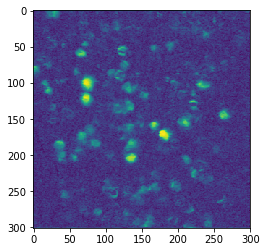

In [38]:
#%% play along side original data
cm.concatenate([m_els.resize(1, 1, downsample_ratio),
                denoised.resize(1, 1, downsample_ratio)], 
                axis=2).play(fr=8, gain=15, magnification=2, offset=0)  # press q to exit
c_img = m_orig.local_correlations(eight_neighbours = True, swap_dim = False) #correlation image
pl.imshow(c_img)